45856638
true:  345.00000000000006
375.79181361228177
true:  2857.999999999999
389.82253548101687
true:  764.9999999999997
405.3603919882076
true:  1119.9999999999993
422.4111037773232
true:  719.0
440.99448326413574
true:  535.9999999999998
461.142304532759
true:  866.9999999999993
482.8967456995266
true:  428.9999999999999
1139.031156771454
true:  2524.9999999999977
897.024270271284
true:  427.9999999999998
677.3804732225145
true:  2346.9999999999995
545.2031574422374
true:  702.9999999999999
463.93487971942267
true:  1154.0
411.90136106563057
true:  3115.9999999999964
377.6759331652648
true:  1090.9999999999993
354.99375123137764
true:  353.99999999999983
340.22784822406317
true:  921.9999999999998
331.17134119107413
true:  2684.0
326.4241753490849
true:  2038.9999999999982
325.0677145837265
true:  3652.000000000001
326.4832810519567
true:  2455.9999999999986
330.24637096582694
true:  23506.999999999993
3767.308521879819
true:  2633.0
4599.311858313974
true:  1392.9999999999995
343.

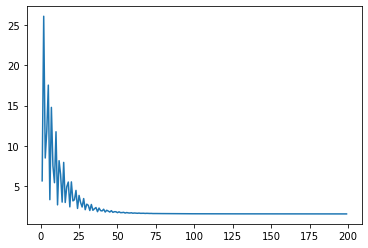

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from math import e, floor, ceil
from datetime import datetime
import time

p: int = 4 # grado del polinomio de nuestro modelo de regresión no lineal

REGION = 0; REGION_ORIG = 1; DATE = 2; CONFIRMED = 3; DEATHS = 4

filename = 'covid.csv'
y_training_ds = []
x_training_ds = []
x_testing_ds = []
y_testing_ds = []

n: int = -1
m: int = -1
q: int = -1

with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    # n = len(list(csv_reader))
    n = 9934
    training_rows = floor(n*0.7)
    m = training_rows
    testing_rows = ceil(n*0.3)
    q = testing_rows
    print('total rows: ', n)
    print('training rows: ', training_rows)
    print('testing rows: ', testing_rows)
    idx: int = 0
    offset: int = datetime.strptime("01/01/2020", "%m/%d/%Y").timestamp()

    for row in csv_reader:
        if idx != 0:
          marca_de_tiempo: int = datetime.strptime(str(row[DATE]), "%m/%d/%Y").timestamp()
          nueva_marca_de_tiempo: float = (marca_de_tiempo - offset)/(3600 * 24)
          # print(nueva_marca_de_tiempo)
          new_x = [1, np.log(float(nueva_marca_de_tiempo)), np.log(float(row[REGION])), np.log(float(row[REGION_ORIG]))]
          new_y = np.log(float(row[DEATHS]))
          if idx <= training_rows:
            #print('training row')
            x_training_ds.append(new_x)
            y_training_ds.append(new_y)
          else:
            #print('testing row')
            x_testing_ds.append(new_x)
            y_testing_ds.append(new_y)
        idx += 1

print('total rows after insertion: ', n)
print('training rows after insertion: ', len(x_training_ds))
print('testing rows after insertion: ', len(x_testing_ds))

# rs = RandomState(MT19937(SeedSequence(123456789))); rs.rand(4)
w = np.random.rand(p)
landa = 0.0015
alfa = 0.0000025
gamma = 0.9
v = [0] * p
print(w)
# hipótesis
def h(w, x, j):
  # w: parametros
  # x: vector de caracteristicas
  # return: valor que predice el modelo 'h' para el j-esimo data point 
  return np.sum([w[i]*(x[j][i]**i) for i in range(p)]) 

def rms(vec):
  return np.sqrt((np.sum([vec[i]**2 for i in range(p)]))/(p))

# true = y_ds
# pred = h(x_training_ds)
def mse(true, h):
  return np.sum([(true[i] - h(w, x_training_ds, i))**2 for i in range(m)])/(2*m)

# true = y_ds
# pred = h(x_training_ds)
def mae(true, h):
  return np.sum([np.abs(true[i] - h(w, x_training_ds, i)) for i in range(m)])/m


def derivada_l1(true, h, l, w, j, x):
  term1 = np.sum([((true[i]-h(w, x, i)) / (np.abs(true[i]-h(w, x, i))))*(-x[i][j]**j) for i in range(m)])
  return term1

def derivada_l2(true, h, l, w, j, x):
  term1 = np.sum([ (true[i] - h(w, x, i))*(-x[i][j]**j) for i in range(m) ])/m
  return term1


def derivada_l2_regularizada(true, h, l, w, j, x):
  term1 = np.sum([ (true[i] - h(w, x, i))*(-x[i][j]**j) for i in range(m) ])/m
  term2 = l*2*w[j]
  return term1 + term2

def derivada_l1_regularizada(true, h, l, w, j, x):
  term1 = np.sum([((true[i]-h(w, x, i)) / (np.abs(true[i]-h(w, x, i))))*(-x[i][j]**j) for i in range(m)])
  return term1 + (l*(w[j]/np.abs(w[j])))

unidades = []
errores = []

epsilon = pow(10, -8)

def test():
  k = 1
  e_w = [0] * (p)
  while (k < 100):
    unidades.append(k)
    
    grads = [derivada_l2_regularizada(y_training_ds, h, landa, w, j, x_training_ds) for j in range(p)]
    rms_grads = rms(grads)
    parameter = [(-(alfa/rms_grads))*grads[i] for i in range(p)]
    e_w = [gamma*e_w[i] + (1-gamma)*parameter[i]**2 for i in range(p)]
    delta = [np.sqrt(e_w[i]+epsilon) for i in range(p)]

    for i in range(p):
      w[i] = w[i] - delta[i]*grads[i]

    err = mse(y_training_ds, h)
    errores.append(err)
    # print(err)
    k += 1

start = time.time()
test()
end = time.time()
print('lambda: ', landa)
print('alfa: ', alfa)
print('time: ', end - start)
print('error: ', mse(y_training_ds, h))
# print(unidades)
# print(errores)
# plt.plot(unidades, errores)

# for i in range(q-1):
#     row = x_testing_ds[i]
#     true = y_testing_ds[i]
#     print('true: ', e**true)
#     print(e**h(w, x_testing_ds, i))

   # 1.48 landa 1 alfa 0.003
   # 1.47 landa 1.5  """"
   # 1.466 landa 1.5 0.0025
